0. Параметры данных
* Датасет: Train_target_fields
 
shape: (NumSamples, C, H, W)

      - NumSamples: (20000)
  
      - C: 3 канала:
  
            0-й sigma_xx
            1-й sigma_yy
            2-й sigma_xy
  
      - H: 128
  
      - W: 128
  
* Датасет: Train_input_params
  
shape: (NumSamples, C, H, W)

      - NumSamples: (20000) 
      
      - C: 4 канала:
      
            0-й канал со значением координаты x в каждой точке карты
            1-й канал со значением координаты y в каждой точке карты
            2-й канал со значением радиуса отверстия в каждой точке карты (константный канал)
            3-й канал со значением приложенной нагрузки к пластине в каждой точке карты (константный канал)
            
      - H: 128
      
      - W: 128
      
* Датасет: Val_target_fields

shape: (NumSamples, C, H, W)

      - NumSamples: (2000)
      
      - C: 3 канала:
      
            0-й sigma_xx
            1-й sigma_yy
            2-й sigma_xy
            
      - H: 128
      
      - W: 128
      
* Датасет: Val_input_params
  
shape: (NumSamples, C, H, W)

      - NumSamples: (2000) 
      
      - C: 4 канала:
      
            0-й канал со значением координаты x в каждой точке карты
            1-й канал со значением координаты y в каждой точке карты
            2-й канал со значением радиуса отверстия в каждой точке карты (константный канал)
            3-й канал со значением приложенной нагрузки к пластине в каждой точке карты (константный канал)
            
      - H: 128
      
      - W: 128
* Датасет: Test_target_fields

shape: (NumSamples, C, H, W)

      - NumSamples: (10) 
      
      - C: 3 канала:
      
            0-й sigma_xx
            1-й sigma_yy
            2-й sigma_xy
            
      - H: 128
      
      - W: 128
* Датасет: Test_input_params
  
shape: (NumSamples, C, H, W)

      - NumSamples: (10)
      
      - C: 4 канала:
      
            0-й канал со значением координаты x в каждой точке карты
            1-й канал со значением координаты y в каждой точке карты
            2-й канал со значением радиуса отверстия в каждой точке карты (константный канал)
            3-й канал со значением приложенной нагрузки к пластине в каждой точке карты (константный канал)
            
      - H: 128
      
      - W: 128


------------------
Внутренние параметры генерации  

      - область вычислений: (xmin, xmax, ymin, ymax) (-1.0, 1.0, -1.0, 1.0)
      
      - диапазон радиусов отверстия: (a_min, a_max) (0.05, 0.1)
      
      - диапазон нагрузки (sigma_min, sigma_max) (2e3, 1e4)


1. Подготовка датасета для сети

In [1]:
import torch
class ToMinusOneToOne:
    """
    Нормализует каждое значение тензора (С, H, W) к значению из отрезка [-1, 1] (поканально) 
    
    Args
    mins : list  список минимумов каналов 
    maxs : list  список максимумов каналов
    channel_mask : индексы каналов которые нужно нормализовать
    """
    def __init__(self, mins, maxs, channel_mask=None):
        mins = torch.as_tensor(mins, dtype=torch.float32)
        maxs = torch.as_tensor(maxs, dtype=torch.float32)
        if mins.shape != maxs.shape:
            raise ValueError("mins and maxs must same length")
        self.register_buffer("mins", mins.view(-1, 1, 1))
        self.register_buffer("maxs", maxs.view(-1, 1, 1))
        self.channel_mask = channel_mask  

    def register_buffer(self, name, tensor):
        setattr(self, name, tensor)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        if self.channel_mask is None:
            x = x.clone()
            for i in range(x.shape[0]):
                x[i] = 2.0 * (x[i] - self.mins[i]) / (self.maxs[i] - self.mins[i]) - 1.0
            return x
        else:
            x = x.clone()
            for i in self.channel_mask:
                x[i] = 2.0 * (x[i] - self.mins[i]) / (self.maxs[i] - self.mins[i]) - 1.0
            return x

class FromMinusOneToOne:
    """
    Обратное преобразование
    """
    def __init__(self, mins, maxs, channel_mask=None):
        mins = torch.as_tensor(mins, dtype=torch.float32)
        maxs = torch.as_tensor(maxs, dtype=torch.float32)
        self.register_buffer("mins", mins.view(-1, 1, 1))
        self.register_buffer("maxs", maxs.view(-1, 1, 1))
        self.channel_mask = channel_mask

    def register_buffer(self, name, tensor):
        setattr(self, name, tensor)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        x = x.clone()                       # keep original untouched
        if self.channel_mask is None:
            x = (x + 1) * 0.5 * (self.maxs - self.mins) + self.mins
        else:
            mask = torch.tensor(self.channel_mask, dtype=torch.long)
            x[mask] = (x[mask] + 1) * 0.5 * (self.maxs[mask] - self.mins[mask]) + self.mins[mask]
        return x

In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
class KirschDS(torch.utils.data.Dataset):
    def __init__(self, input_file, target_file, transform_input=None, transform_target=None):
        # mmap_mode, чтобы не занимать всю память
        self.inp = np.load(input_file, mmap_mode='r')
        self.target = np.load(target_file, mmap_mode='r')
        self.target = np.nan_to_num(self.target, nan=0.0)
        self.transform_target = transform_target
        self.transform_input = transform_input
    def __len__(self): 
        return self.target.shape[0]
    def __getitem__(self, idx):
        inp = torch.from_numpy(self.inp[idx]).float() # (4, N, N)
        target = torch.from_numpy(self.target[idx]).float()  # (3, N, N)
        if self.transform_target:
            target = self.transform_target(target)
        if self.transform_input:
            inp = self.transform_input(inp)
        return torch.tensor(inp, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


In [3]:
# x, y, a , P 
MIN_INPUT = [ -1.0, -1.0, 0.05, 2000.0 ]
MAX_INPUT = [ 1.0, 1.0, 0.10 , 10000.0 ]
# s_xx , s_yy , s_xy
MIN_TARGET = [-1.0e5 , -1.0e5 , -1.0e5 ] #Значения для sigma номинальные
MAX_TARGET = [ 1.0e5 ,  1.0e5 ,  1.0e5 ]

In [4]:
norm_input = ToMinusOneToOne(MIN_INPUT, MAX_INPUT, channel_mask=[2,3])
denorm_input = FromMinusOneToOne(MIN_INPUT, MAX_INPUT, channel_mask=[2,3])

norm_target = ToMinusOneToOne(MIN_TARGET, MAX_TARGET, channel_mask=[0,1,2])
denorm_target = FromMinusOneToOne(MIN_TARGET, MAX_TARGET, channel_mask=[0,1,2])

In [5]:
train_dataset = KirschDS('train_input_params.npy', 'train_target_fields.npy', transform_input=norm_input, transform_target=norm_target)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False) #Генерация случайная, перемешивать не надо

val_dataset = KirschDS('val_input_params.npy', 'val_target_fields.npy', transform_input=norm_input, transform_target=norm_target)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [5]:
test_dataset = KirschDS('test_input_params.npy', 'test_target_fields.npy', transform_input=norm_input, transform_target=norm_target)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

2. Построение нейросети.

   Преобразование: тензор координат и параметров (C_in, N, N) -> (C_out, N, N) тензор решения
                                                 (4, 128, 128) -> (3, 128, 128) 

Encoder (32→64→128→256→512)      4× downsample
Bottleneck  (2‑3 ResBlocks)

Decoder (512→256→128→64→32)      4× upsample + skip
Head     Conv(32→3, 1×1)
Fuse (a,P) via FiLM or constant maps

In [6]:
import torch.nn as nn
class ParamCoordUNet(nn.Module):
    def __init__(self, out_channels=3):
        super().__init__()
        self.encoder = nn.Sequential(
            #128x128
            nn.Conv2d(4, 64, kernel_size=3, stride=2), #63x63
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2), #31x31
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2), #15x15
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(256, 512, kernel_size=3, stride=2), #7x7
            nn.BatchNorm2d(512),
            nn.ReLU(),
            
        )
        self.decoder = nn.Sequential(
            #7x7
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2), #15x15
            nn.BatchNorm2d(256),
            nn.ReLU(),
    
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2), #31x31
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2), #63x63
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2), #128x128
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 3, kernel_size=2, padding=1), #128x128
            
        )

    def forward(self, x):  # (B, 4, H, W)
        x = self.encoder(x)
        x = self.decoder(x)
        return x # (B, 3, H, W)

3. Обучение сети

In [7]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ParamCoordUNet(3).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.L1Loss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5)

In [8]:
def evaluate(model, dataloader, loss_fn):
    model.eval() 
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            batch_size = inputs.size(0)
            total_loss += loss.item() * batch_size  # аккумулируем по всем объектам
            total_samples += batch_size

    avg_loss = total_loss / total_samples
    return avg_loss

In [9]:
import time
def train(model, loss_fn, optimizer, num_epochs=50):
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0
        total_train_samples = 0
        model.train(True)
        for batch_input, batch_target in train_loader:
            batch_input = batch_input.to(device) # (B, 4, H, W)
            batch_target = batch_target.to(device) # (B, 3, H, W)
            
            outputs = model(batch_input) # (B, 3, H, W)
            loss = loss_fn(outputs, batch_target)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # Накапливаем лосс, умножая на размер батча
            batch_size = batch_input.size(0)
            total_train_loss += loss.item() * batch_size
            total_train_samples += batch_size
        
        # Усредняем по количеству реальных сэмплов
        avg_train_loss = total_train_loss / total_train_samples
        
        model.train(False)
        val_loss = evaluate(model, val_loader, loss_fn=loss_fn)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss_train: {avg_train_loss:.6f}, Loss_val: {val_loss:.6f}")
        
        scheduler.step(val_loss)
        
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Текущий LR после шага: {current_lr:.6f}")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Общее время обучения: {total_time:.2f} сек., "
          f"среднее время на эпоху: {total_time/num_epochs:.2f} сек.")
    return model

In [12]:
model = train(model, loss_fn, optimizer, num_epochs=50)

/tmp/ipykernel_14879/632613900.py:15: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  inp = torch.from_numpy(self.inp[idx]).float() # (4, N, N)
/tmp/ipykernel_14879/632613900.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(inp, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


Epoch 1/50, Loss_train: 0.018046, Loss_val: 0.005654
Текущий LR после шага: 0.001000
Epoch 2/50, Loss_train: 0.004030, Loss_val: 0.002714
Текущий LR после шага: 0.001000
Epoch 3/50, Loss_train: 0.002952, Loss_val: 0.002192
Текущий LR после шага: 0.001000
Epoch 4/50, Loss_train: 0.002426, Loss_val: 0.002086
Текущий LR после шага: 0.001000
Epoch 5/50, Loss_train: 0.002203, Loss_val: 0.001848
Текущий LR после шага: 0.001000
Epoch 6/50, Loss_train: 0.002153, Loss_val: 0.001912
Текущий LR после шага: 0.001000
Epoch 7/50, Loss_train: 0.001999, Loss_val: 0.001663
Текущий LR после шага: 0.001000
Epoch 8/50, Loss_train: 0.001854, Loss_val: 0.001696
Текущий LR после шага: 0.001000
Epoch 9/50, Loss_train: 0.001830, Loss_val: 0.001466
Текущий LR после шага: 0.001000
Epoch 10/50, Loss_train: 0.001823, Loss_val: 0.001242
Текущий LR после шага: 0.001000
Epoch 11/50, Loss_train: 0.001808, Loss_val: 0.001424
Текущий LR после шага: 0.001000
Epoch 12/50, Loss_train: 0.001732, Loss_val: 0.001170
Текущий L

In [13]:
#torch.save(model.state_dict(), 'model_weights.pt')

In [10]:
model = ParamCoordUNet(3).to(device)

model.load_state_dict(torch.load('model_weights.pt'))

<All keys matched successfully>

4. Использование обученной сети: построение графиков для правой верхней четверти без отверстия

/tmp/ipykernel_4546/632613900.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(inp, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


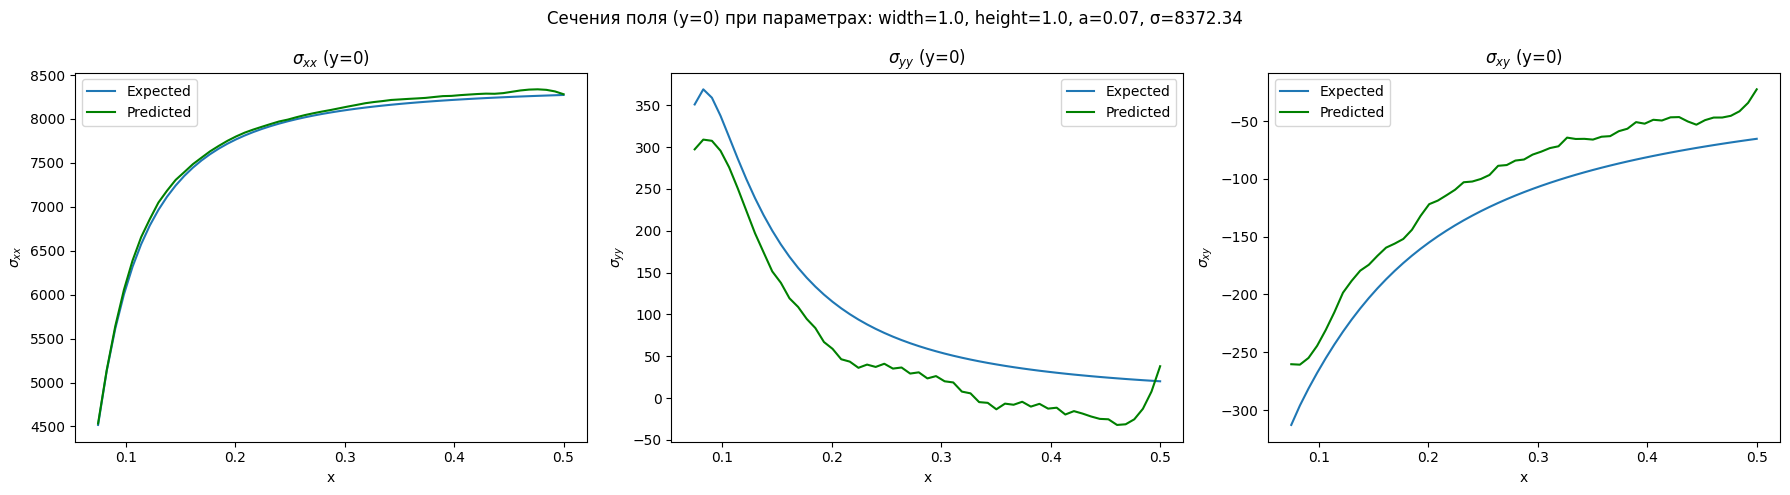

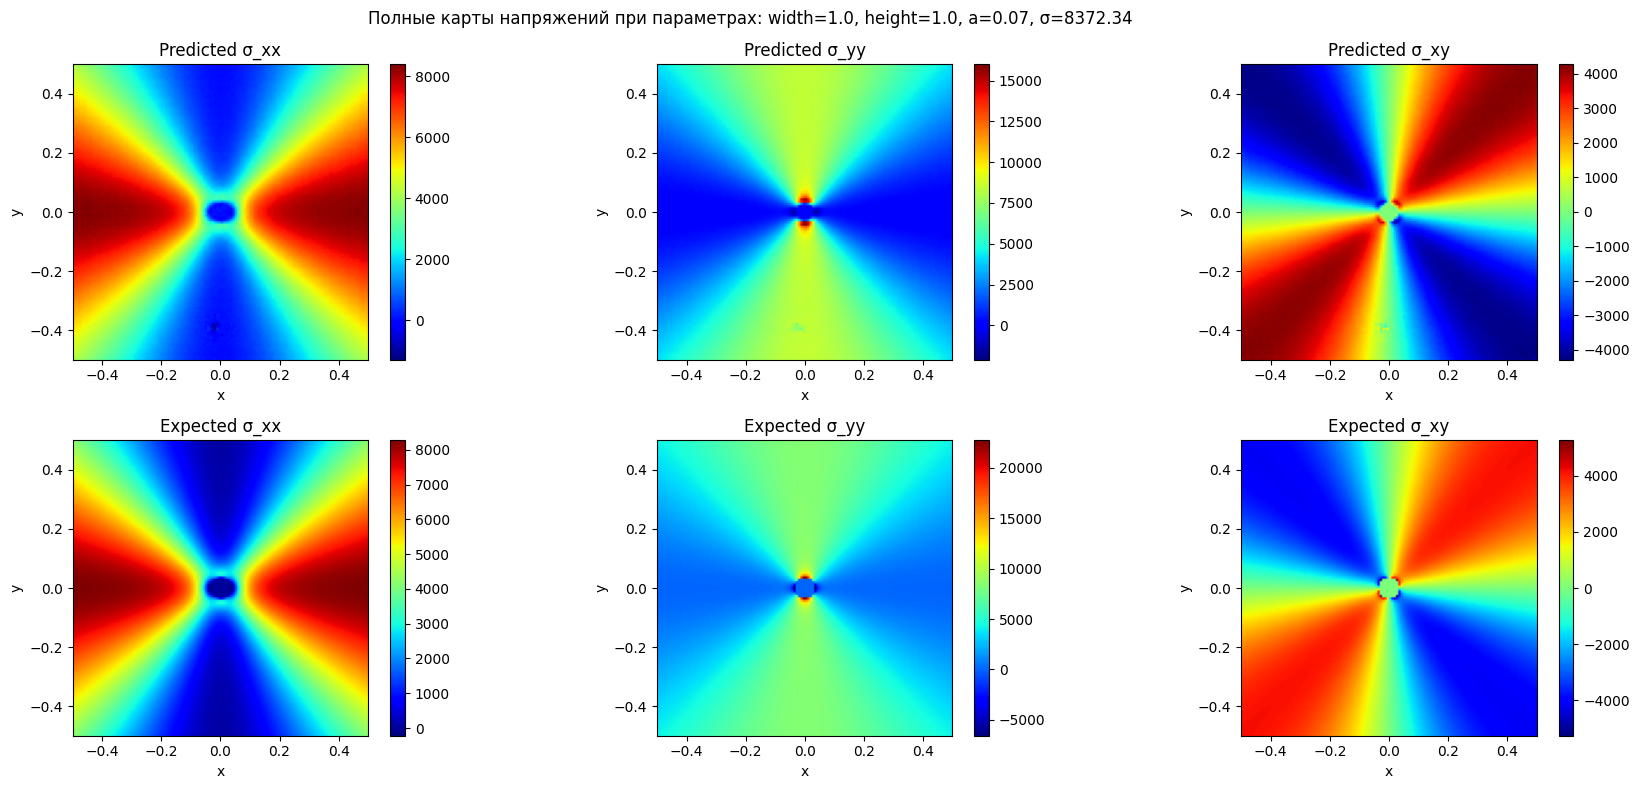

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import torch

model.eval()
device = next(model.parameters()).device

# Один тестовый пример из набора
test_params_tensor, test_field_tensor = test_dataset[0]
test_params_tensor = test_params_tensor.unsqueeze(0).to(device) # (1, 4, H, W)

with torch.no_grad():
    pred_field = model(test_params_tensor).cpu()[0]  # (3, H, W)

test_params_tensor = test_params_tensor.squeeze(0).cpu() # (4, H, W)

# Эталонные данные из датасета 
sample_field = test_field_tensor  # (3, H, W)
sample_params = test_params_tensor # (4, H, W)

# Денормализация
sample_field = denorm_target(sample_field).numpy()
pred_field = denorm_target(pred_field).numpy()
sample_params = denorm_input(sample_params).numpy()

a_sample = sample_params[2][0][0]
P_sample = sample_params[3][0][0]

H, W = (128,128)

x_coords = np.linspace(-1/2, 1/2, W)
y_coords = np.linspace(-1/2, 1/2, H)


# Три графика (сечения) по x=0 для sigma_xx, sigma_yy, sigma_xy

fig_cs, axs_cs = plt.subplots(1, 3, figsize=(18, 5))

# индекс, соответствующий x=0
x0_index = np.argmin(np.abs(x_coords))
# Т.к. мы хотим только правую сторону и учитывать отверстие
mask_y = (y_coords >= a_sample)
mask_x = (x_coords >= a_sample)
# Три канала: 0 -> sigma_xx, 1 -> sigma_yy, 2 -> sigma_xy
titles = [r'$\sigma_{xx}$', r'$\sigma_{yy}$', r'$\sigma_{xy}$']
for ch in range(3):
    # По эталонным данным
    sigma_analyt = sample_field[ch, x0_index, :]
    # По предсказанным данным
    sigma_pred = pred_field[ch, x0_index, :]

    # Берём только y>=a
    y_sec = y_coords[mask_y]
    sigma_analyt_sec = sigma_analyt[mask_y]
    sigma_pred_sec = sigma_pred[mask_y]

    # Уберём NaN
    valid_mask = ~np.isnan(sigma_analyt_sec) & ~np.isnan(sigma_pred_sec)
    y_sec = y_sec[valid_mask]
    sigma_analyt_sec = sigma_analyt_sec[valid_mask]
    sigma_pred_sec = sigma_pred_sec[valid_mask]
    sigma_pred_sec   = savgol_filter(sigma_pred_sec, window_length=11, polyorder=3, mode='interp')
    
    
    axs_cs[ch].plot(y_sec, sigma_analyt_sec, label='Expected')
    axs_cs[ch].plot(y_sec, sigma_pred_sec, label='Predicted', color='green')
    axs_cs[ch].set_title(f"{titles[ch]} (y=0)")
    axs_cs[ch].set_xlabel('x')
    axs_cs[ch].set_ylabel(titles[ch])
    axs_cs[ch].legend()

fig_cs.suptitle(f'Cечения поля (x=0) при параметрах: '
                f'width={1.0}, height={1.0}, '
                f'a={a_sample:.2f}, σ={P_sample:.2f}')
plt.tight_layout()
plt.show()


# 2) Шесть графиков 2D‐карт: Predicted / Expected для 3 компонент

fig_map, axs_map = plt.subplots(2, 3, figsize=(18, 8))

components = ['xx', 'yy', 'xy']
for idx, comp in enumerate(components):
    # Верхний ряд: предсказание
    ax_pred = axs_map[0, idx]
    # mask NaN внутри отверстия (при генерации там NaN)
    im_pred = ax_pred.imshow(pred_field[idx],
                             origin='lower',
                             extent=[x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]],
                             cmap='jet')
    ax_pred.set_title(f'Predicted σ_{comp}')
    ax_pred.set_xlabel('x')
    ax_pred.set_ylabel('y')
    fig_map.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04)

    # Нижний ряд: эталон
    ax_exp = axs_map[1, idx]
    im_exp = ax_exp.imshow(sample_field[idx],
                           origin='lower',
                           extent=[x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]],
                           cmap='jet')
    ax_exp.set_title(f'Expected σ_{comp}')
    ax_exp.set_xlabel('x')
    ax_exp.set_ylabel('y')
    fig_map.colorbar(im_exp, ax=ax_exp, fraction=0.046, pad=0.04)

fig_map.suptitle(f'Полные карты напряжений при параметрах: '
                 f'width={1.0}, height={1.0}, '
                 f'a={a_sample :.2f}, σ={P_sample:.2f}')
plt.tight_layout()
plt.show()